In [1]:
from map.seem.base_model import build_vl_model
model = build_vl_model("seem", input_size = 360)


#* 데이터 경로 설정
root_dir = !pwd
root_dir = root_dir[0]
# !mkdir -p data_demo
# %cd data_demo
# !gdown 1wjuiVcO92Rqer5gLk-X7hINfe4PCMQmu
# !pip install tqdm
# !unzip -o 5LpN3gDmAk7_1.zip | tqdm --desc extracted --unit files --unit_scale --total `unzip -l 5LpN3gDmAk7_1.zip | tail -n 1 | xargs echo -n | cut -d' ' -f2` > /dev/null
# %cd ..
import os
#data_dir = "/home/hong/capstone/vlmaps/data_custom"
scene_id = "1LXtFkjw3qL_1_none"
data_dir = os.path.join(root_dir, "Data/habitat_sim/mp3d", scene_id) #vlmaps_dataset
version = "tb0025_ps50"
#
#* 갖고있는 depth, rgb 이미지를 이용해 비디오로 시각화해주는 작업
#* 단순 시각화용일 뿐이며, VLMaps 제작이나 이후 작업에 사용되지는 않음
# @title Helper functions for video creation and display
import sys
import os
import imageio
import numpy as np
import cv2
import tqdm
from IPython.display import HTML
from base64 import b64encode

# @markdown if the colab instance doesn't have GPU, untick the following checkbox
has_gpu = True # @param {type: "boolean"}
codec = "h264"
if has_gpu:
  codec = "h264_nvenc"

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth

[*] model loaded


In [2]:
import csv
categories = "/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/simulation_dataset/HM3D_CountsOfObjectTypes.csv"
import pandas as pd

# CSV 파일 읽기
df = pd.read_csv(categories, sep=';')
print(df)
object_type_list = df['Object Type Name'].tolist()
print(len(object_type_list))
print(object_type_list)

       Object Type Name   # of instances in semantic text files
0                  wall                                   25036
1               unknown                                    5970
2               picture                                    4471
3               ceiling                                    4440
4                pillow                                    3841
...                 ...                                     ...
1619       hi-hat stand                                       1
1620  sheet music stand                                       1
1621        bath hanger                                       1
1622             buffet                                       1
1623    kitchen ceiling                                       1

[1624 rows x 2 columns]
1624
['wall', 'unknown', 'picture', 'ceiling', 'pillow', 'door', 'lamp', 'door frame', 'floor', 'window', 'cabinet', 'ceiling lamp', 'box', 'book', 'chair', 'window frame', 'decoration', 'shelf', 'table', 'm

In [3]:
# @title Helper functions for video creation and display
import sys
import os
import imageio
import numpy as np
import cv2
import tqdm
from IPython.display import HTML
from base64 import b64encode

# @markdown if the colab instance doesn't have GPU, untick the following checkbox
has_gpu = True # @param {type: "boolean"}
codec = "h264"
if has_gpu:
  codec = "h264_nvenc"

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth

def get_fast_video_writer(video_file: str, fps: int = 60):
    if (
        "google.colab" in sys.modules
        and os.path.splitext(video_file)[-1] == ".mp4"
        and os.environ.get("IMAGEIO_FFMPEG_EXE") == "/usr/bin/ffmpeg"
    ):
        # USE GPU Accelerated Hardware Encoding
        writer = imageio.get_writer(
            video_file,
            fps=fps,
            codec=codec,
            mode="I",
            bitrate="1000k",
            format="FFMPEG",
            ffmpeg_log_level="info",
            quality=10,
            output_params=["-minrate", "500k", "-maxrate", "5000k"],
        )
    else:
        # Use software encoding
        writer = imageio.get_writer(video_file, fps=fps)
    return writer

def create_video(data_dir: str, output_dir: str, fps: int = 30):
    
    rgb_dir = os.path.join(data_dir, "rgb")
    depth_dir = os.path.join(data_dir, "depth")
    rgb_out_path = os.path.join(output_dir, "rgb.mp4")
    depth_out_path = os.path.join(output_dir, "depth.mp4")
    rgb_writer = get_fast_video_writer(rgb_out_path, fps=fps)
    depth_writer = get_fast_video_writer(depth_out_path, fps=fps)

    rgb_list = sorted(os.listdir(rgb_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    depth_list = sorted(os.listdir(depth_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))

    rgb_list = [os.path.join(rgb_dir, x) for x in rgb_list]
    depth_list = [os.path.join(depth_dir, x) for x in depth_list]
    pbar = tqdm.tqdm(total=len(rgb_list), position=0, leave=True)
    for i, (rgb_path, depth_path) in enumerate(zip(rgb_list, depth_list)):
        bgr = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        depth = load_depth(depth_path)
        depth_vis = (depth / 10 * 255).astype(np.uint8)

        depth_color = cv2.applyColorMap(depth_vis, cv2.COLORMAP_JET)

        rgb_writer.append_data(rgb)
        depth_writer.append_data(depth_color)
        pbar.update(1)
    rgb_writer.close()
    depth_writer.close()

def show_video(video_path, video_width = 1080):
   
    video_file = open(video_path, "r+b").read()
  
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} autoplay controls><source src="{video_url}"></video>""")

def show_videos(video_paths, video_width = 1080):
    html = ""
    for video_path in video_paths:
        video_file = open(video_path, "r+b").read()
      
        video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
        html += f"""<video width={video_width} autoplay controls><source src="{video_url}"></video>
                 """
    return HTML(html)

In [4]:
# create_video(data_dir, data_dir, fps=30)

In [5]:
# show rgb and depth
# show_videos([data_dir + "/rgb.mp4", data_dir + "/depth.mp4"])

In [6]:

#* setup VLMaps parameters
# @markdown meters per cell size
cs = 0.025 # @param {type: "number"} #* 셀 크기 당 미터 단위
# @markdown map resolution (gs x gs)
gs = 2000 # @param {type: "integer"} #* 맵의 해상도 (그리드 수 _ 정수 단위)
# @markdown camera height (used for filtering out points on the floor)
camera_height = 1.5 # @param {type: "number"} #* 카메라 높이 (바닥에 있는 점을 필터링하는 데 사용)
# @markdown depth pixels subsample rate
depth_sample_rate = 10 # @param {type: "integer"} #* depth 정보의 픽셀 sampling rate
# @markdown data where rgb, depth, pose are loaded and map are saved
data_dir = data_dir # @param {type: "string"} #* 데이터 경로

In [7]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from map.utils.mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
from map.utils.clip_utils import get_text_feats
from map.utils.matterport3d_categories import mp3dcat #* 여기엔 그 장애물이 리스트 형태로 저장되어있음
import clip

In [8]:
use_self_built_map = True # @param {type: "boolean"} 
map_save_dir = os.path.join(data_dir, "map")
if use_self_built_map:
    map_save_dir = os.path.join(data_dir, f"map/{scene_id}_{version}")
os.makedirs(map_save_dir, exist_ok=True)

color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_{version}.npy")
grid_save_path = os.path.join(map_save_dir, f"grid_{version}.npy")
obstacles_save_path = os.path.join(map_save_dir, f"obstacles_{version}.npy")
# obstacles_save_path = "/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/vlmaps_dataset/apartment_0_1/map/obstacles_test.npy"
weight_save_path = os.path.join(map_save_dir, f"weight_{version}.npy")
background_grid_save_path = os.path.join(map_save_dir, f"background_grid_{version}.npy")
category_map_save_path = os.path.join(map_save_dir, f"category_map_{version}.npy")
instance_map_save_path = os.path.join(map_save_dir, f"instance_map_{version}.npy")
# gt_save_path = os.path.join(map_save_dir, f"grid_lseg_gt.npy")
print(data_dir)
print(grid_save_path)

/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/mp3d/1LXtFkjw3qL_1_none
/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/mp3d/1LXtFkjw3qL_1_none/map/1LXtFkjw3qL_1_none_tb0025_ps50/grid_tb0025_ps50.npy


(2000, 2000)
(2000, 2000, 3)
[0 1]


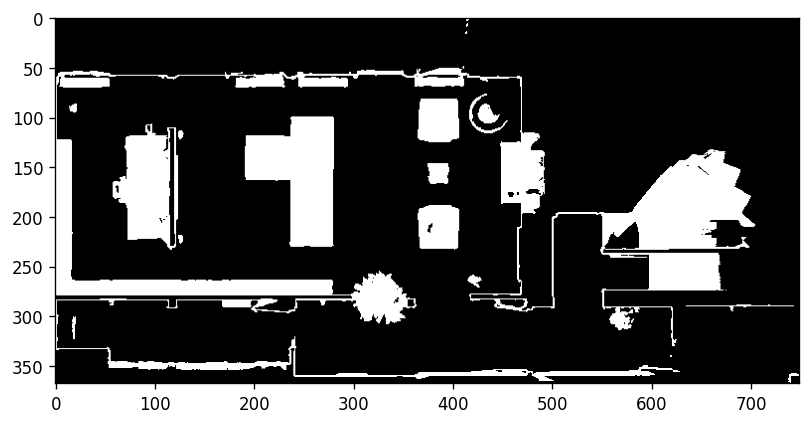

In [9]:
obstacles = load_map(obstacles_save_path)
color_top_down = load_map(color_top_down_save_path)
print(obstacles.shape)
print(color_top_down.shape)
x_indices, y_indices = np.where(obstacles == 1)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(np.unique(obstacles))
obstacles_pil = Image.fromarray(obstacles[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.show()

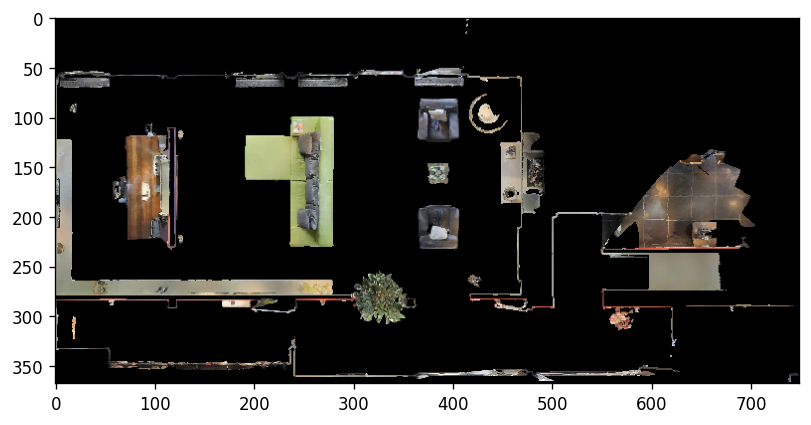

In [10]:
color_top_down = load_map(color_top_down_save_path)
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]
color_top_down_pil = Image.fromarray(color_top_down)
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(color_top_down_pil)
plt.savefig(os.path.join(map_save_dir, f"rgbtopdown_{version}.png"), bbox_inches='tight', pad_inches=0.1)
plt.show()

In [11]:
%%capture
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
grid = load_map(grid_save_path)
print(grid.shape)
grid = grid[xmin:xmax+1, ymin:ymax+1]
print(grid.shape)
print(grid_save_path)
# print(grid[100,100].keys())
# print(grid)

(2000, 2000)
(368, 749)
/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/mp3d/1LXtFkjw3qL_1_none/map/1LXtFkjw3qL_1_none_tb0025_ps50/grid_tb0025_ps50.npy


In [13]:
# print(grid)
# print(np.unique(grid))
# background_grid = load_map(background_grid_save_path)
# background_grid = background_grid[xmin:xmax+1, ymin:ymax+1]
# print(background_grid.shape)
# bbackground_grid = np.zeros_like(background_grid)
# bbackground_grid[background_grid == 1] = 2
# bbackground_grid[background_grid == 2] = 1

In [14]:
# 

In [15]:
query = ["void","table in the kitchen"]
query = [
    "void",
    "wall",
    "floor",
    "chair",
    "door",
    "table",
    "picture",
    "cabinet",
    "cushion",
    "window",
    "sofa",
    "bed",
    "curtain",
    "chest_of_drawers",
    "plant",
    "sink",
    "stairs",
    "ceiling",
    "toilet",
    "stool",
    "towel",
    "mirror",
    "tv_monitor",
    "shower",
    "column",
    "bathtub",
    "counter",
    "fireplace",
    "lighting",
    "beam",
    "railing",
    "shelving",
    "blinds",
    "gym_equipment",
    "seating",
    "board_panel",
    "furniture",
    "appliances",
    "clothes",
    "objects",
]

q_replica = [
    "undefined",
    "bin",
    "bottle",
    "camera",
    "chair",
    "clock",
    "cushion",
    "ceiling",
    "door",
    "floor",
    "lamp",
    "panel",
    "sofa",
    "stool",
    "table",
    "tablet",
    "tissue-paper",
    "tv-screen",
    "vent",
    "wall",
    "wall-plug",
    "window"
]

q_replica = [
    'undefined',
    'backpack',
    'base-cabinet',
    'basket',
    'bathtub',
    'beam',
    'beanbag',
    'bed',
    'bench',
    'bike', 
    'bin',
    'blanket', 
    'blinds', 
    'book', 
    'bottle', 
    'box', 
    'bowl', 
    'camera', 
    'cabinet',
    'candle',
    'chair',
    'chopping-board',
    'clock',
    'cloth',
    'clothing',
    'coaster',
    'comforter',
    'computer-keyboard',
    'cup',
    'cushion',
    'curtain',
    'ceiling',
    'cooktop',
    'countertop',
    'desk',
    'desk-organizer',
    'desktop-computer',
    'door',
    'exercise-ball',
    'faucet',
    'floor',
    'handbag',
    'hair-dryer',
    'handrail',
    'indoor-plant',
    'knife-block',
    'kitchen-utensil',
    'lamp', 
    'laptop', 
    'major-appliance', 
    'mat', 
    'microwave', 
    'monitor', 
    'mouse', 
    'nightstand', 
    'pan', 
    'panel', 
    'paper-towel', 
    'phone', 
    'picture', 
    'pillar', 
    'pillow', 
    'pipe', 
    'plant-stand', 
    'plate', 
    'pot', 
    'rack', 
    'refrigerator', 
    'remote-control', 
    'scarf', 
    'sculpture', 
    'shelf', 
    'shoe', 
    'shower-stall', 
    'sink', 
    'small-appliance', 
    'sofa', 
    'stair', 
    'stool', 
    'switch', 
    'table', 
    'table-runner', 
    'tablet', 
    'tissue-paper', 
    'toilet', 
    'toothbrush', 
    'towel', 
    'tv-screen', 
    'tv-stand', 
    'umbrella', 
    'utensil-holder', 
    'vase', 
    'vent', 
    'wall', 
    'wall-cabinet', 
    'wall-plug', 
    'wardrobe', 
    'window', 
    'rug', 
    'logo', 
    'bag', 
    'set-of-clothing']

q_new = [
    "void",
    "base-cabinet",
    "basket",
    "bathtub",
    "beanbag",
    "bed",
    "bench",
    "bike",
    "bin",
    "blanket",
    "blinds",
    "book",
    "bottle",
    "bowl",
    "box",
    "cabinet",
    "camera",
    "candle",
    "ceiling",
    "chair",
    "chopping-board",
    "clock",
    "clothing",
    "comforter",
    "cooktop",
    "countertop",
    "cup",
    "curtain",
    "cushion",
    "desk",
    "desk-organizer",
    "door",
    "faucet",
    "floor", 
    "handbag",
    "handrail",
    "indoor-plant",
    "knife-block",
    "lamp",
    "major-appliance",
    "mat",
    "nightstand",
    "panel",
    "picture",
    "pillar",
    "pillow",
    "pipe",
    "plant-stand",
    "plate",
    "pot",
    "rack",
    "refrigerator",
    "rug",
    "scarf",
    "sculpture",
    "shelf",
    "shoe",
    "shower-stall",
    "sink",
    "small-appliance",
    "sofa",
    "stair",
    "stool",
    "switch",
    "table",
    "tablet",
    "tissue-paper",
    "toilet",
    "tv-screen",
    "tv-stand",
    "umbrella",
    "utensil-holder",
    "vase",
    "vent",
    "wall",
    "wall-cabinet",
    "wall-plug",
    "window"]

# query = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'banner', 'blanket', 'bridge', 'cardboard', 'counter', 'curtain', 'door-stuff', 'floor-wood', 'flower', 'fruit', 'gravel', 'house', 'light', 'mirror-stuff', 'net', 'pillow', 'platform', 'playingfield', 'railroad', 'river', 'road', 'roof', 'sand', 'sea', 'shelf', 'snow', 'stairs', 'tent', 'towel', 'wall-brick', 'wall-stone', 'wall-tile', 'wall-wood', 'water-other', 'window-blind', 'window-other', 'tree-merged', 'fence-merged', 'ceiling-merged', 'sky-other-merged', 'cabinet-merged', 'table-merged', 'floor-other-merged', 'pavement-merged', 'mountain-merged', 'grass-merged', 'dirt-merged', 'paper-merged', 'food-other-merged', 'building-other-merged', 'rock-merged', 'wall-other-merged', 'rug-merged']

# query = mp3dcat = ['undefined', 'base-cabinet', 'basket', 'bathtub', 'bed', 'blinds', 'book', 'bottle', 'cabinet', 'chair', 'comforter', 'cup', 'cushion', 'curtain', 'ceiling', 'cooktop', 'countertop', 'desk', 'door', 'faucet', 'floor', 'handrail', 'indoor-plant', 'lamp', 'major-appliance', 'mat', 'nightstand', 'panel', 'picture', 'pillow', 'plant-stand', 'plate', 'pot', 'rack', 'refrigerator', 'shower-stall', 'sink', 'sofa', 'stair', 'stool', 'switch', 'table', 'toilet', 'vase', 'vent', 'wall', 'wall-cabinet', 'wall-plug', 'window']#, 'rug']
# query = [
#     "undefined",
#     "blinds",
#     "book",
#     "comforter",
#     "ceiling",
#     "countertop",
#     "desk",
#     "door",
#     "floor",
#     "indoor-plant",
#     "lamp",
#     "major-appliance",
#     "mat",
#     "nightstand",
#     "picture",
#     "plant-stand",
#     "plate",
#     "rack",
#     "table",
#     "vase",
#     "wall",
#     "wall-plug",
#     "window",
#     "rug",
#     "lighting",
# ]
# query = [
#     "void",
#     "wall",
#     "floor",
#     "chair",
#     "door",
#     "table",
#     "picture",
#     "cabinet",
#     "cushion",
#     "window",
#     "sofa",
#     "bed",
#     "curtain",
#     "sink",
#     "stairs"
# ]

# query = [
#     "void",
# #    "floor",
#     "bed_room in a scene"
# ]
t_emb = model.encode_prompt(q_new, task="default")

aa = t_emb.cpu().numpy()
print(aa.shape)

# query = ["table","computer"]
# t_emb = model.encode_prompt(query, task="default")
# aa = t_emb.cpu().numpy()

# print(aa.shape)
# qq = ["computer on the table"]
# tt = model.encode_prompt(qq, task="default")
# bb = tt.cpu().numpy()



(78, 512)


In [16]:
import pickle

embeddings_path = os.path.join(map_save_dir, f"instance_dict_{version}.pkl")

print(embeddings_path)


#"/home/hong/VLMAPS/vlseem/Data/habitat/vlmaps_dataset/2t7WUuJeko7_2_mini/map/instance_dict_dummy_geo_dist4.pkl"

with open(embeddings_path, 'rb') as f:
    embeddings = pickle.load(f)

no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(embeddings.keys())

/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/mp3d/1LXtFkjw3qL_1_none/map/1LXtFkjw3qL_1_none_tb0025_ps50/instance_dict_tb0025_ps50.pkl
dict_keys([1, 2, 3, 4, 5, 7, 8, 14, 16, 19, 20, 21, 23, 24, 26, 27, 29, 30, 31, 34, 35, 37, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 61, 62, 63, 83, 86, 87, 88, 89, 93, 110, 112, 116, 130, 151, 156, 163, 166, 167, 169, 172, 180, 182, 183, 184, 191, 192, 194, 198, 207, 222, 223, 225, 226, 228, 231, 232, 236, 247, 249, 251, 254, 255, 257, 258, 259, 260, 261, 262, 264, 265, 267, 270, 273, 277, 280])


In [17]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(np.unique(grid))
print(embeddings.keys())
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
# ids=[]
# for i in range(grid.shape[0]):
#     for j in range(grid.shape[1]):
#         for arg in grid[i,j].keys():
#             if arg not in ids:
#                 ids.append(arg)
# embeddings[1]["avg_height"] = 0
# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    # print(val["embedding"],val["embedding"].shape)
    instance_feat.append(val["embedding"])
# print(instance_feat, type(instance_feat))
print(instance_feat[0].shape)
for i in instance_feat:
    if i.shape[0] == 1 and i.shape[1] == 512: print(i.shape)
print(len(instance_feat[0]))
instance_feat = np.array(instance_feat)

# instance_feat = np.vstack([aa[:2,:],instance_feat])

# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# ggrid_map[background_grid == 1] = 2
# ggrid_map[background_grid == 2] = 1
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        key = grid[i,j]
        if key == 0 : continue

        candidate = predicts[list(embeddings.keys()).index(key)]
        ggrid_map[i,j] = candidate
            
floor_mask = ggrid_map == 2
mask2 = ggrid_map == 0
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(q_replica))
mask, patches = get_new_mask_pallete(ggrid_map, new_pallete, out_label_flag=True, labels=q_replica)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
# seg[mask2] = [225,225,225,225]
seg = Image.fromarray(seg)



# ggrid_map_save_path = os.path.join(map_save_dir, f"ggrid_{mask_version}.npy")
# np.save(ggrid_map_save_path, ggrid_map)

plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.savefig(os.path.join(map_save_dir, f"indexmap_height{version}.png"), bbox_inches='tight', pad_inches=0.1)
plt.show()
print(os.path.join(map_save_dir, f"indexmap_height{version}.png"),)

TypeError: '<' not supported between instances of 'dict' and 'dict'

In [18]:
# # # 좌표에 0이 키값으로 있는 포인트만 선택하여 ggrid_map 생성
# # ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# # for i in range(grid.shape[0]):
# #     for j in range(grid.shape[1]):
# #         if 5 in grid[i, j]:
# #             ggrid_map[i, j] = 1  # 0 키를 가진 포인트는 1로 표시

# # # 시각화를 위해 1이 있는 곳만 표시
# # plt.figure(figsize=(10, 6), dpi=120)
# # plt.imshow(ggrid_map, cmap="gray")
# # plt.axis('off')
# # plt.title("Points with Key 0")

# # plt.show()
# import numpy as np
# import matplotlib.pyplot as plt

# # 시각화를 위한 설정
# plt.figure(figsize=(10, 6), dpi=120)
# print(embeddings.keys())
# # k값을 0부터 287까지 변경하면서 시각화
# for n,id in enumerate(embeddings.keys()):
#     # 좌표에 k가 키값으로 있는 포인트만 선택하여 ggrid_map 생성
#     ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
#     ggrid_map[grid == id] =1
#     # maskk = embeddings[id]["mask"]
#     # print(maskk.shape)
#     # print(np.sum(maskk))
#     # # 시각화를 위해 1이 있는 곳만 표시
#     # plt.clf()  # 이전 이미지 지우기
#     # plt.imshow(maskk, cmap="gray")
#     if n==0:
#         np.save(os.path.join(map_save_dir, f"wall_mask.npy"), ggrid_map)

#     plt.clf()  # 이전 이미지 지우기
#     name = predicts[n]
#     print(query[name])
#     print(ggrid_map.shape)

#     print(np.sum(ggrid_map))
#     plt.imshow(ggrid_map, cmap="gray")


#     plt.axis('off')
#     plt.title(f"Points with Key {id}")
#     plt.draw()  # 현재 상태를 그리기
#     plt.pause(0.5)  # 0.5초 간격으로 업데이트 (시간 조정 가능)

#     plt.show()


(368, 749)
embeddings: 88
(88, 78)
78


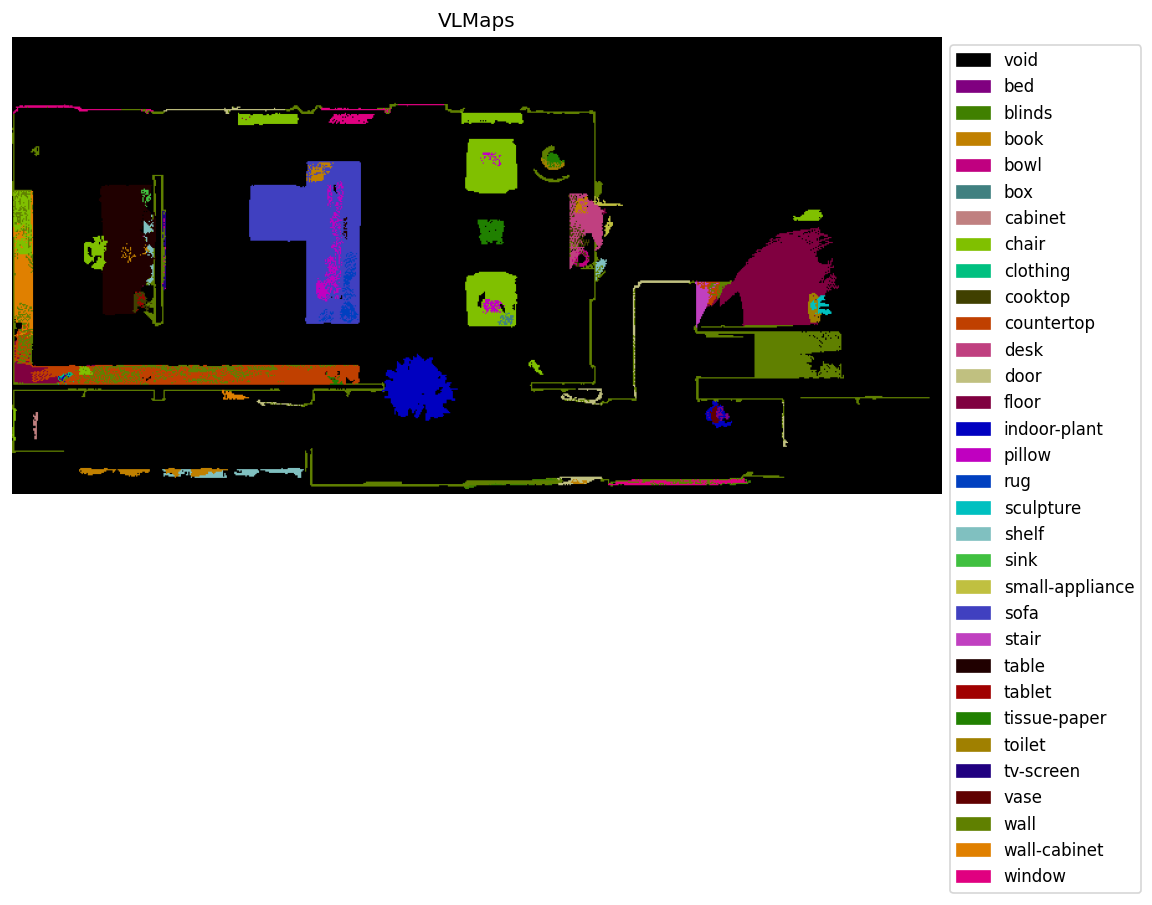

/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/mp3d/1LXtFkjw3qL_1_none/map/1LXtFkjw3qL_1_none_tb0025_ps50/indexmap_heighttb0025_ps50.png


In [19]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)
embeddings[1]["avg_height"] = 0
# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)

# instance_feat = np.vstack([aa[:2,:],instance_feat])

# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
print(scores_list.shape)
print(len(aa))
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# ggrid_map[background_grid == 1] = 2
# ggrid_map[background_grid == 2] = 1
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        if len(grid[i,j].keys()) == 1:
            # print(grid[i,j][0])
            for key in grid[i,j].keys():
                # if key in [1,0]:
                #     ggrid_map[i,j]=key
                #     continue

                if q_new[predicts[list(embeddings.keys()).index(key)]] == "lamp": continue
                ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        else:
            max_conf = 0
            max_height = 50000
            max_observed = 0
            for key, val in grid[i,j].items():
                if key == 2 :continue
                # print(arg)
                # print(predicts.shape)
                # if key in [1,0]: continue
                candidate = predicts[list(embeddings.keys()).index(key)]
                if q_new[candidate] == "lamp": continue
                candidate_conf = val[0]
                candidate_height = val[1]
                candidate_observed = val[2]
                # if max_conf < candidate_conf:
                #     max_conf = candidate_conf
                #     candidate_val = candidate
                if max_height > candidate_height:
                    max_height = candidate_height
                    candidate_val = candidate
                # if candidate_observed > max_observed:
                #     max_observed = candidate_observed
                #     candidate_val = candidate
            ggrid_map[i,j] = candidate_val
            
floor_mask = ggrid_map == 2
mask2 = ggrid_map == 0
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(q_new))
mask, patches = get_new_mask_pallete(ggrid_map, new_pallete, out_label_flag=True, labels=q_new)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
# seg[mask2] = [225,225,225,225]
seg = Image.fromarray(seg)



# ggrid_map_save_path = os.path.join(map_save_dir, f"ggrid_{mask_version}.npy")
# np.save(ggrid_map_save_path, ggrid_map)

plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.savefig(os.path.join(map_save_dir, f"indexmap_height{version}.png"), bbox_inches='tight', pad_inches=0.1)
plt.show()
print(os.path.join(map_save_dir, f"indexmap_height{version}.png"),)

In [14]:
# # 108 395
# print(embeddings[1]["avg_height"])
# print(embeddings[5]["avg_height"])
# print(embeddings[6]["avg_height"])

(236, 185)
embeddings: 256


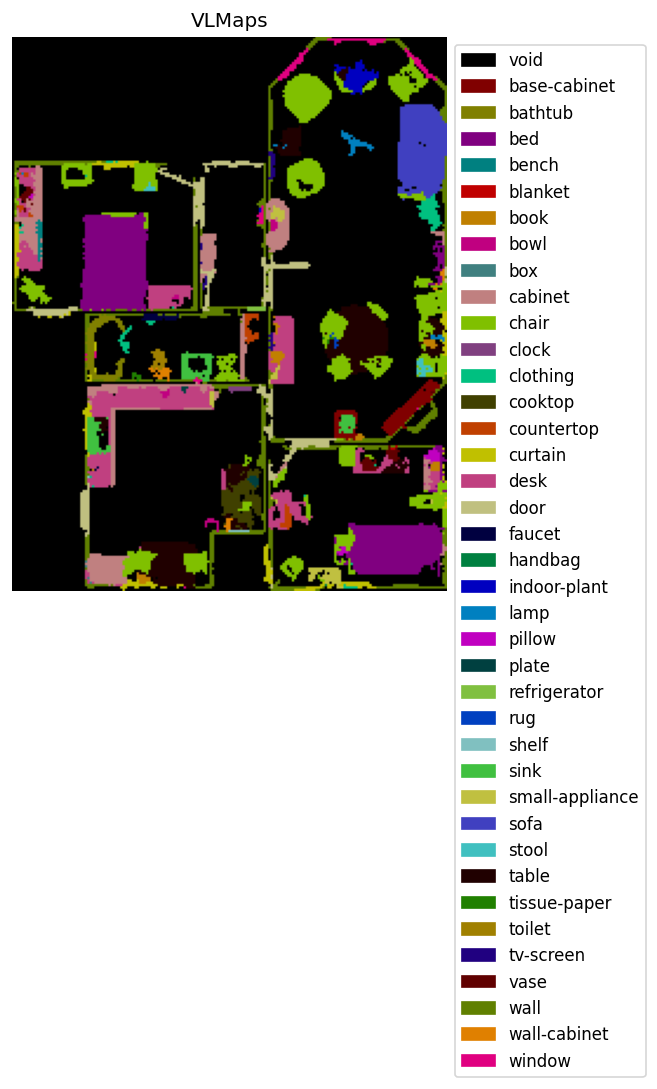

In [15]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

embeddings[1]["avg_height"] = 2
embeddings[2]["avg_height"] = 1.5
# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)

# instance_feat = np.vstack([aa[:2,:],instance_feat])

# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# ggrid_map[background_grid == 1] = 2
# ggrid_map[background_grid == 2] = 1
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        if len(grid[i,j].keys()) == 1:
            # print(grid[i,j][0])
            for key in grid[i,j].keys():
                # if key in [1,0]:
                #     ggrid_map[i,j]=key
                #     continue
                # if q_new[predicts[list(embeddings.keys()).index(key)]] == "lighting": continue
                ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        else:
            max_conf = 0
            max_height = 50000
            max_observed = 0
            for key, val in grid[i,j].items():
                # print(arg)
                # print(predicts.shape)
                # if key in [1,0]: continue
                if key == 2 :continue
                candidate = predicts[list(embeddings.keys()).index(key)]
                # if q_new[predicts[list(embeddings.keys()).index(key)]] == "lighting": continue
                candidate_conf = val[0]
                candidate_height = embeddings[key]["avg_height"]
                candidate_observed = val[2]
                # if max_conf < candidate_conf:
                #     max_conf = candidate_conf
                #     candidate_val = candidate
                if max_height > candidate_height:
                    max_height = candidate_height
                    candidate_val = candidate
                # if candidate_observed > max_observed:
                #     max_observed = candidate_observed
                #     candidate_val = candidate
            ggrid_map[i,j] = candidate_val
floor_mask = ggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(q_new))
mask, patches = get_new_mask_pallete(ggrid_map, new_pallete, out_label_flag=True, labels=q_new)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)



# ggrid_map_save_path = os.path.join(map_save_dir, f"ggrid_{mask_version}.npy")
# np.save(ggrid_map_save_path, ggrid_map)

plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.savefig(os.path.join(map_save_dir, f"indexmap_avg{version}.png"), bbox_inches='tight', pad_inches=0.1)
plt.show()

In [16]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)
# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.empty_like(grid, dtype=dict)
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        ggrid_map[i,j] = {}
        
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        # if len(grid[i,j].keys()) == 1:
        #     # print(grid[i,j][0])
        for key in grid[i,j].keys():
            if query[predicts[list(embeddings.keys()).index(key)]] == "lighting": continue
            # if key == 2 :continue
            new_key = predicts[list(embeddings.keys()).index(key)]
            ggrid_map[i,j][new_key] = grid[i,j][key][2]
                # ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        # else:
        #     max_conf = 0
        #     max_height = 0
        #     # candidate_val = 0
        #     for key, val in grid[i,j].items():
        #         # print(arg)
        #         # print(predicts.shape)
        #         candidate = predicts[list(embeddings.keys()).index(key)]
        #         candidate_conf = val[0]
        #         candidate_height = val[2]
        #         # if max_conf < candidate_conf:
        #         #     max_conf = candidate_conf
        #         #     candidate_val = candidate
        #         if max_height < candidate_height:
        #             max_height = candidate_height
        #             candidate_val = candidate
        #     ggrid_map[i,j] = candidate_val

center_weight = 3
gggrid_map = np.zeros_like(ggrid_map, dtype=np.uint8)
grid_upper = np.empty((ggrid_map.shape[0]+1, ggrid_map.shape[1]+1), dtype=dict)
for i in range(ggrid_map.shape[0]+1):
    for j in range(ggrid_map.shape[1]+1):
        grid_upper[i,j] = {}
grid_upper[1:,1:] = ggrid_map
for i in range(1,gggrid_map.shape[0]+1):
    for j in range(1,gggrid_map.shape[1]+1):
        candidate = grid_upper[i-1:i+2,j-1:j+2]
        item_dict = {}
        for candidate_i in range(candidate.shape[0]):
            for candidate_j in range(candidate.shape[1]):
                if candidate_i == i and candidate_j == j:
                    # if len(candidate[candidate_i,candidate_j]) == 0: continue
                    for key, val in candidate[candidate_i,candidate_j].items():
                        if key in item_dict.keys():
                            item_dict[key] += center_weight #* val
                        else: item_dict[key] = center_weight #* val
                else:
                    # if len(candidate[candidate_i,candidate_j]) == 0: continue
                    for key, val in candidate[candidate_i,candidate_j].items():
                        if key in item_dict.keys():
                            item_dict[key] += 1 #* val
                        else: item_dict[key] = 1 #*  val
        if len(item_dict) ==0:
            gggrid_map[i-1,j-1] = 0
            continue
        max_key = max(item_dict, key=item_dict.get)
        gggrid_map[i-1,j-1] = max_key


floor_mask = gggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(gggrid_map, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.savefig(os.path.join(map_save_dir, f"indexmap_mode{version}.png"), bbox_inches='tight', pad_inches=0.1)
plt.show()

(236, 185)
embeddings: 256


IndexError: list index out of range

In [17]:
category_map = load_map(category_map_save_path)
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)

# instance_feat = np.vstack([aa[:2,:],instance_feat])

# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# ggrid_map[background_grid == 1] = 2
# ggrid_map[background_grid == 2] = 1
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        if len(grid[i,j].keys()) == 1:
            # print(grid[i,j][0])
            for key in grid[i,j].keys():
                # if key in [1,0]:
                #     ggrid_map[i,j]=key
                #     continue
                ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        else:
            max_conf = 0
            max_height = 50000
            max_observed = 0
            for key, val in grid[i,j].items():
                # print(arg)
                # print(predicts.shape)
                # if key in [1,0]: continue
                candidate = predicts[list(embeddings.keys()).index(key)]
                candidate_conf = val[0]
                candidate_height = val[1]
                candidate_observed = val[2]
                # if max_conf < candidate_conf:
                #     max_conf = candidate_conf
                #     candidate_val = candidate
                # if max_height > candidate_height:
                #     max_height = candidate_height
                #     candidate_val = candidate
                if candidate_observed > max_observed:
                    max_observed = candidate_observed
                    candidate_val = candidate
            ggrid_map[i,j] = candidate_val
floor_mask = ggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(category_map, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)



# ggrid_map_save_path = os.path.join(map_save_dir, f"ggrid_{mask_version}.npy")
# np.save(ggrid_map_save_path, ggrid_map)

plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/mp3d/2t7WUuJeko7_2/map/2t7WUuJeko7_2_dummy_d5c005usi/category_map_dummy_d5c005usi.npy'

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

instance_map = load_map(instance_map_save_path)

# unique한 인스턴스 인덱스 값을 가져옴
unique_indices = np.unique(instance_map)
print(len(unique_indices))
num_colors = len(unique_indices)

# 임의의 색상 리스트 생성
colors = plt.cm.nipy_spectral(np.linspace(0, 1, num_colors))
cmap = ListedColormap(colors)

# 인덱스 값이 각 고유 인덱스에 매핑되도록 색상 매핑
index_to_color = {idx: i for i, idx in enumerate(unique_indices)}
colored_map = np.vectorize(index_to_color.get)(instance_map)

# 시각화
plt.figure(figsize=(10, 10))
plt.imshow(colored_map, cmap=cmap)  
plt.colorbar(ticks=range(num_colors), label='Index Value')  # 고유한 색상 바 추가
plt.title('Map Visualization by Index Values')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/vlmaps_dataset/apartment_2_2/map/apartment_2_2_test1224_params_bbox_semSim_pre09/instance_map_test1224_params_bbox_semSim_pre09.npy'

In [23]:
import numpy as np

if np.all((instance_map == 1) == (category_map == 2)):
    print("same")


NameError: name 'instance_map' is not defined

In [24]:
for id in np.unique(instance_map):
    if id ==0:continue
    ha = np.zeros_like(instance_map)
    ha[instance_map == id] = 1

    plt.clf()  # 이전 이미지 지우기
    # name = predicts[id-1]
    # print(query[name])
    print(ha.shape)
    print(np.sum(ha))
    plt.imshow(ha, cmap="gray")


    plt.axis('off')
    plt.title(f"Points with Key {id}")
    plt.draw()  # 현재 상태를 그리기
    plt.pause(0.5)  # 0.5초 간격으로 업데이트 (시간 조정 가능)

    plt.show()

NameError: name 'instance_map' is not defined

In [23]:

fff = model.encode_prompt(["floor-other-merged"],task = "default")
fff = fff.cpu().numpy()

aa = aa / np.linalg.norm(aa)
norms = np.linalg.norm(aa, axis=1, keepdims=True)
aa_n = aa/norms
print(aa_n.shape)
print(aa.shape)

temp1 = 2
temp2 = 3

temp1_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
temp2_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# temp1_feat = instance_feat[temp1]

temp1_feat = embeddings[temp1]["embedding"]
temp1_mask = embeddings[temp1]["mask"]
temp1_feat = temp1_feat / np.linalg.norm(temp1_feat)
# temp2_feat = instance_feat[temp2]
temp2_feat = embeddings[temp2]["embedding"]
temp2_mask = embeddings[temp2]["mask"]
temp2_feat = temp2_feat / np.linalg.norm(temp2_feat)


print(f"Size: {np.sum(temp1_mask)} {np.sum(temp2_mask)}")

# # print(query[predicts[temp1-1]])
# # print(query[predicts[temp2-1]])
# # print(predicts)
# # print(embeddings.keys())
# fff = fff / np.linalg.norm(fff)
# print(temp1_feat@fff.T)
# print(temp2_feat@fff.T)
# print(temp2_feat@aa_n.T)
# # print(fff@aa_n.T)
# print(np.argmax(temp2_feat@aa.T))
# print(query[np.argmax(temp2_feat@aa.T)])

semSim = temp1_feat @ temp2_feat.T
print(f"semSim: {semSim}")
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if temp1 in grid[i,j]:
            temp1_map[i,j] = 1
        if temp2 in grid[i,j]:
            temp2_map[i,j] = 1
print(f"size2: {np.sum(temp1_map)} {np.sum(temp2_map)}")
union_map = np.logical_or(temp1_map, temp2_map).astype(int)
intersection_map = np.logical_and(temp1_map, temp2_map).astype(int)

uu=np.logical_or(temp1_mask, temp2_mask).astype(int)
ii=np.logical_and(temp1_mask, temp2_mask).astype(int)
iiou = np.sum(ii) / np.sum(uu)
print(f"IIoU: {iiou:.3f} (for checking the mask is correct)")


iou = np.sum(intersection_map) / np.sum(union_map)


temp1_center = np.argwhere(temp1_map == 1).mean(axis=0)
temp2_center = np.argwhere(temp2_map == 1).mean(axis=0)
center_dist = np.linalg.norm(temp1_center - temp2_center)

# temp1_bbox = calculate_bbox(temp1_map)
# temp2_bbox = calculate_bbox(temp2_map)
# iou_bbox = calculate_iou_bbox(temp1_bbox, temp2_bbox)


print(f"Center Point : temp1 {temp1_center}, temp2 {temp2_center}")
# print(f"bbox IoU: {iou_bbox:.3f}")
print(f"IoU: {iou:.3f}, Center Distance: {center_dist:.3f}")
print(f"Cosine Similarity: {semSim}")

contours1, _ = cv2.findContours(temp1_map.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(temp2_map.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


lengths1 = [len(contour) for contour in contours1]
if len(contours1) == 0:
    raise Exception("no contour")
contour1 = contours1[np.argmax(lengths1)].squeeze(axis=1)
lengths2 = [len(contour) for contour in contours2]
contour2 = contours2[np.argmax(lengths2)].squeeze(axis=1)
# haus12 = directed_hausdorff(contour1, contour2)[0]
# haus21 = directed_hausdorff(contour2, contour1)[0]
# hausdorff_distance = (haus12 + haus21) / 2
# print(f"Hausdorff Distance: {hausdorff_distance}")

(78, 512)
(78, 512)
Size: 34075 50000
semSim: 0.2878813147544861
size2: 34075 50000
IIoU: 0.449 (for checking the mask is correct)
Center Point : temp1 [210.0647102  158.49511372], temp2 [199.56442 192.21216]
IoU: 0.449, Center Distance: 35.314
Cosine Similarity: 0.2878813147544861


88
dict_keys([1, 2, 3, 4, 5, 7, 8, 14, 16, 19, 20, 21, 23, 24, 26, 27, 29, 30, 31, 34, 35, 37, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 61, 62, 63, 83, 86, 87, 88, 89, 93, 110, 112, 116, 130, 151, 156, 163, 166, 167, 169, 172, 180, 182, 183, 184, 191, 192, 194, 198, 207, 222, 223, 225, 226, 228, 231, 232, 236, 247, 249, 251, 254, 255, 257, 258, 259, 260, 261, 262, 264, 265, 267, 270, 273, 277, 280])
wall
(368, 749)
11421


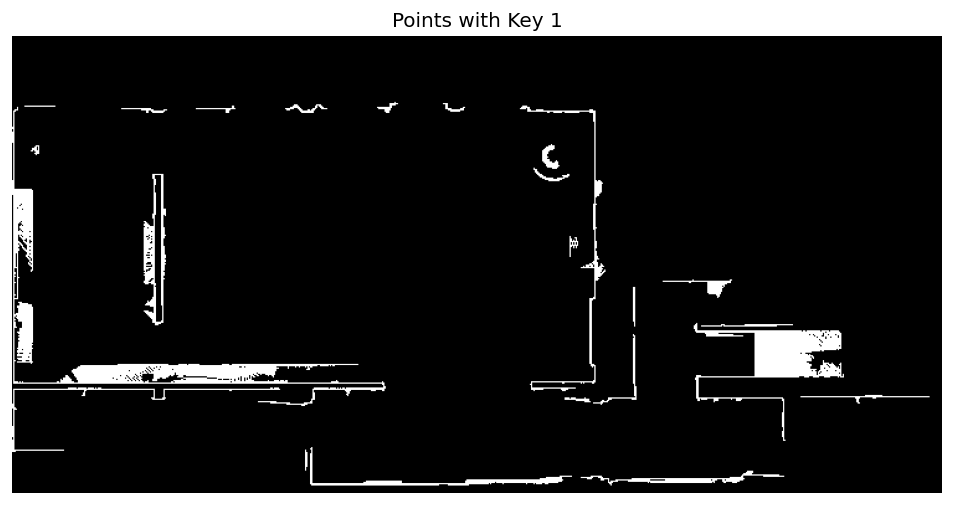

floor
(368, 749)
11851


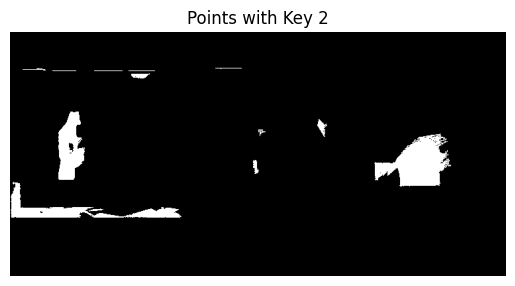

chair
(368, 749)
1642


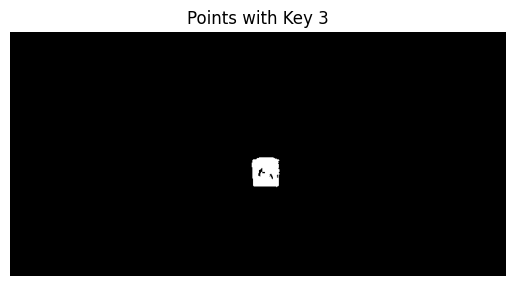

lamp
(368, 749)
76


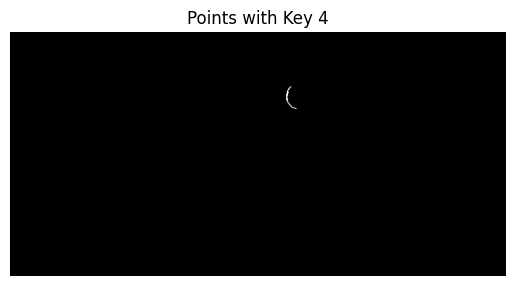

chair
(368, 749)
1722


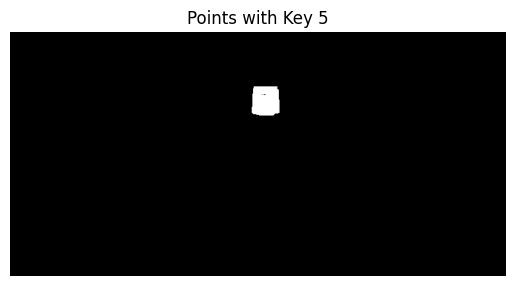

desk
(368, 749)
1027


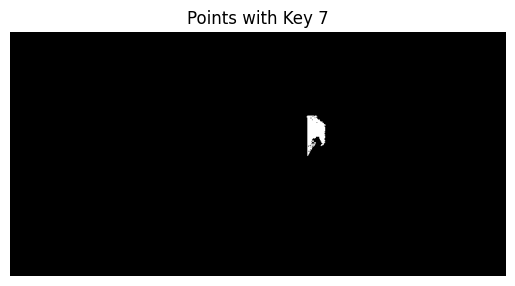

bowl
(368, 749)
128


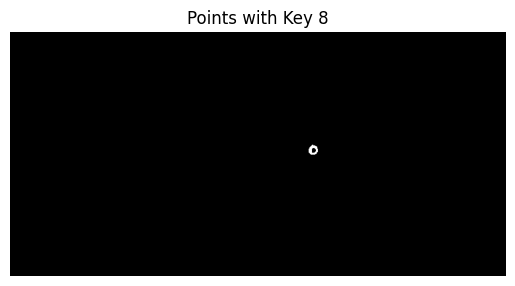

window
(368, 749)
145


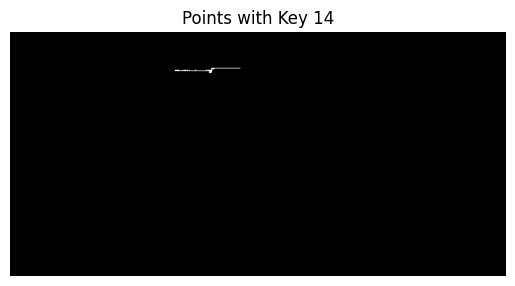

sofa
(368, 749)
7629


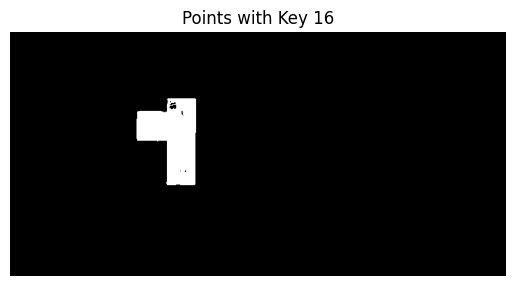

window
(368, 749)
229


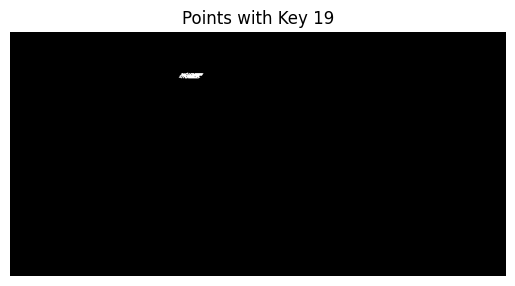

pillow
(368, 749)
1068


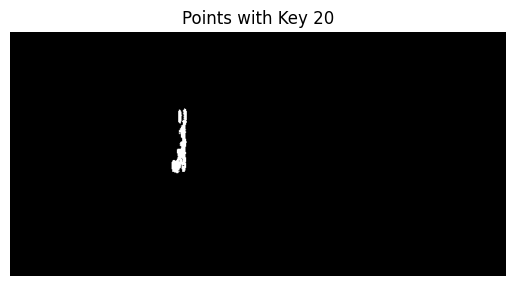

countertop
(368, 749)
3862


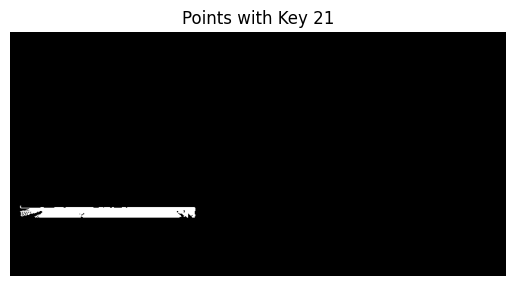

indoor-plant
(368, 749)
1956


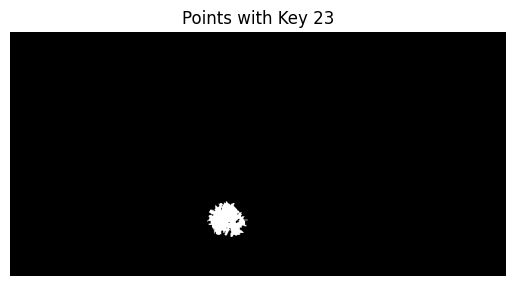

rug
(368, 749)
99


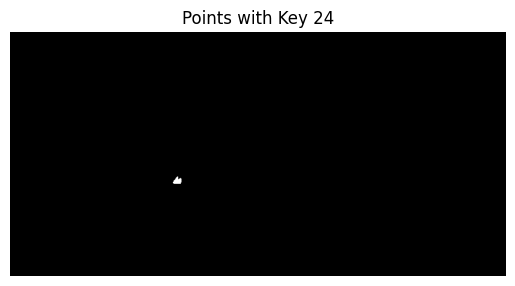

window
(368, 749)
98


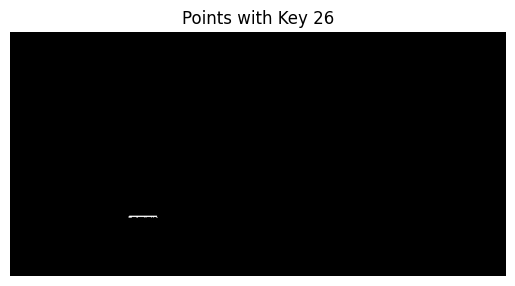

pillow
(368, 749)
174


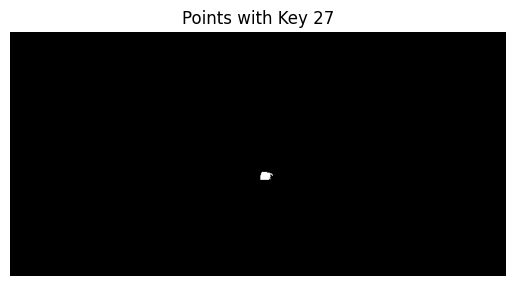

book
(368, 749)
133


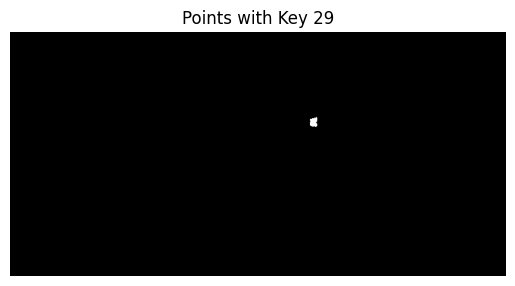

rug
(368, 749)
433


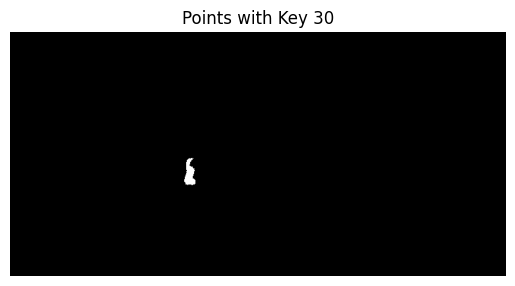

tissue-paper
(368, 749)
73


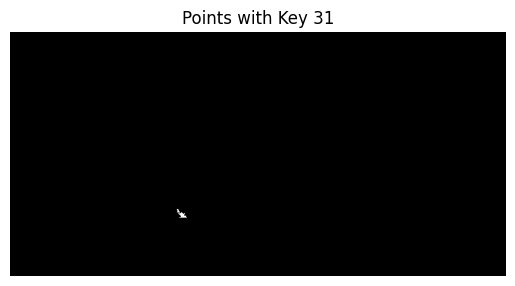

blinds
(368, 749)
293


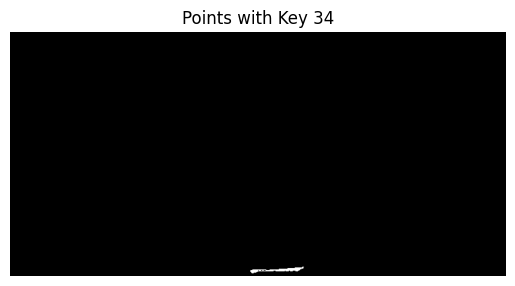

cooktop
(368, 749)
80


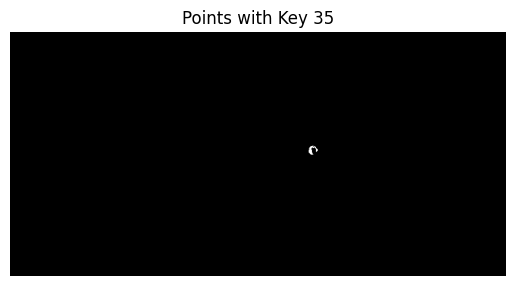

box
(368, 749)
111


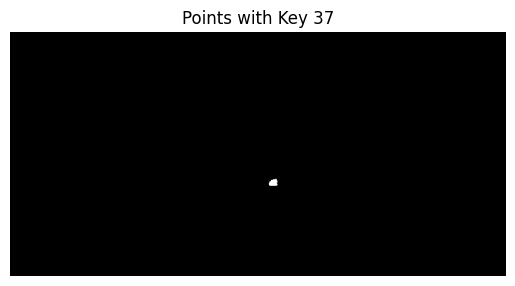

door
(368, 749)
147


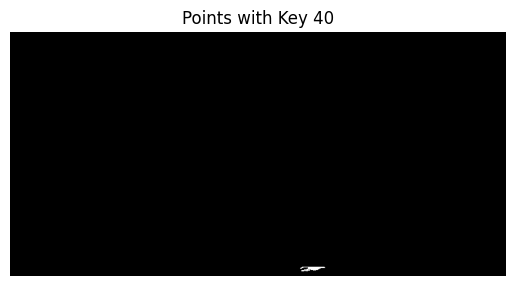

shelf
(368, 749)
103


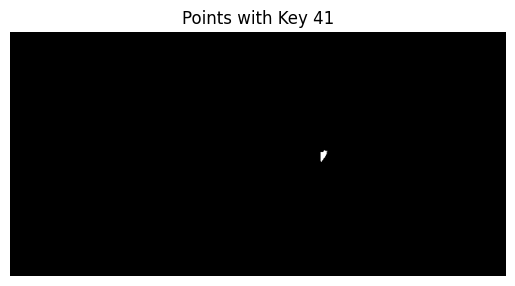

small-appliance
(368, 749)
51


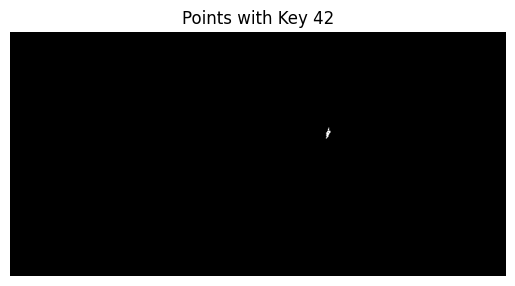

wall
(368, 749)
57


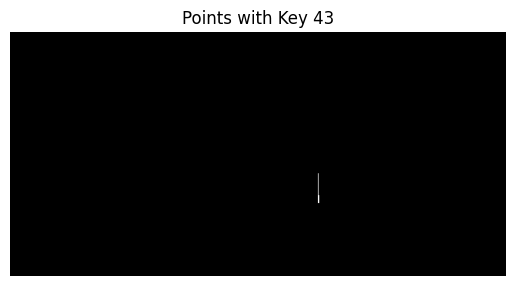

small-appliance
(368, 749)
65


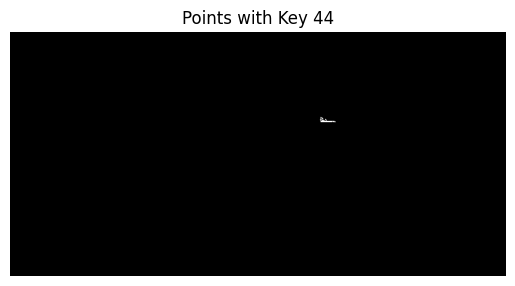

toilet
(368, 749)
103


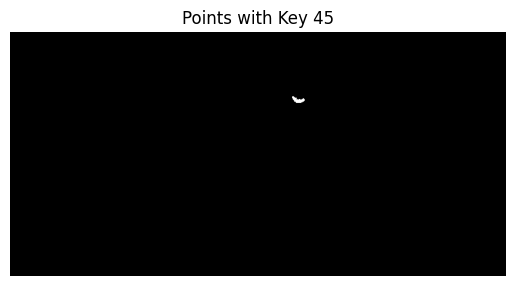

tissue-paper
(368, 749)
350


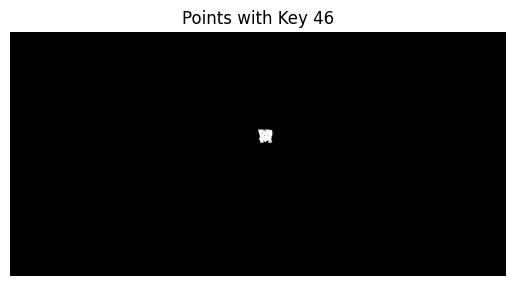

tissue-paper
(368, 749)
162


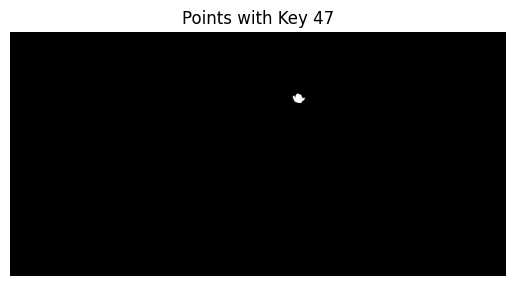

pillow
(368, 749)
155


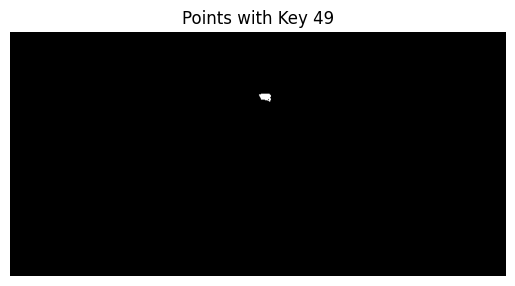

lamp
(368, 749)
64


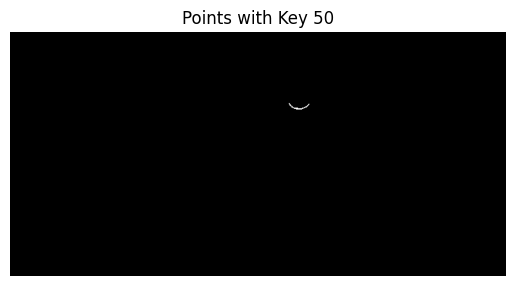

chair
(368, 749)
391


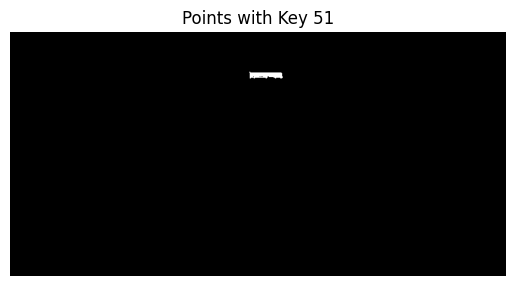

chair
(368, 749)
396


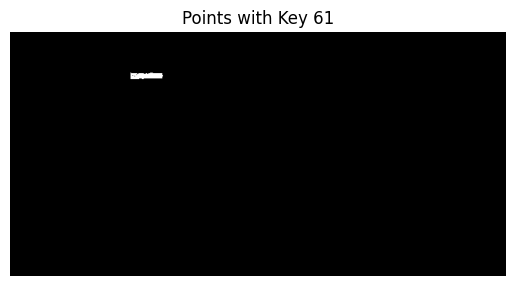

book
(368, 749)
270


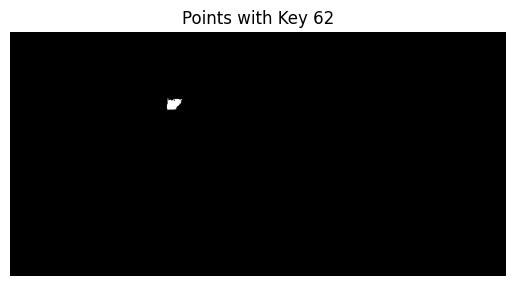

door
(368, 749)
125


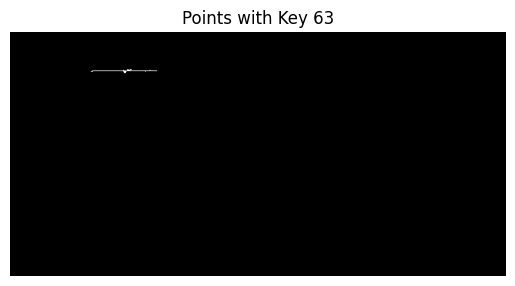

tv-screen
(368, 749)
155


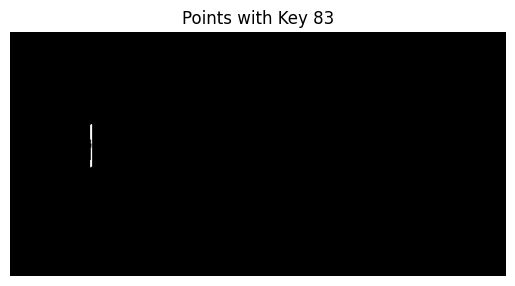

window
(368, 749)
100


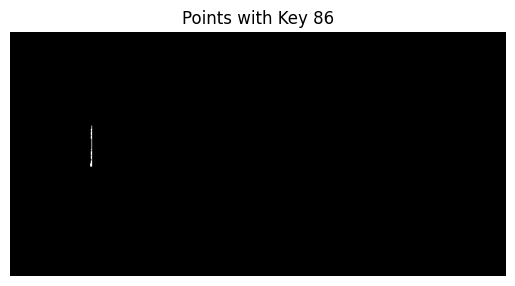

scarf
(368, 749)
69


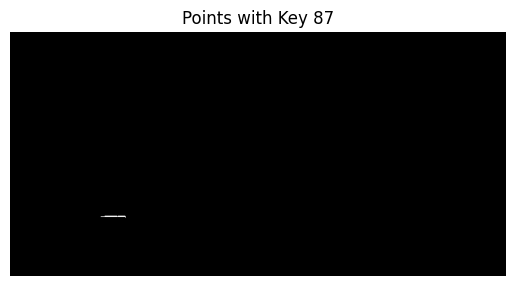

window
(368, 749)
84


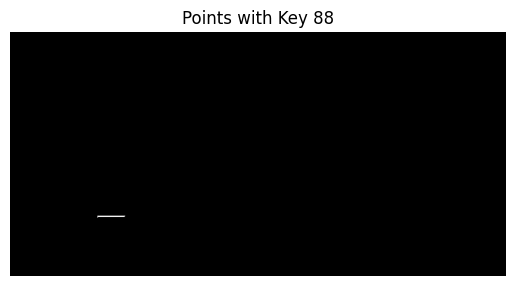

table
(368, 749)
3797


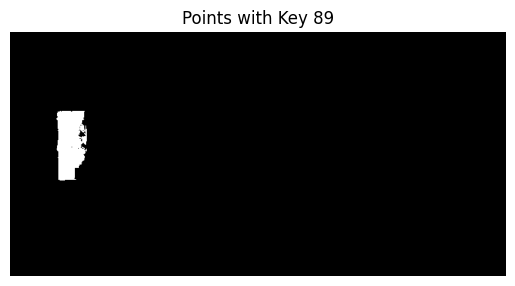

wall-cabinet
(368, 749)
1331


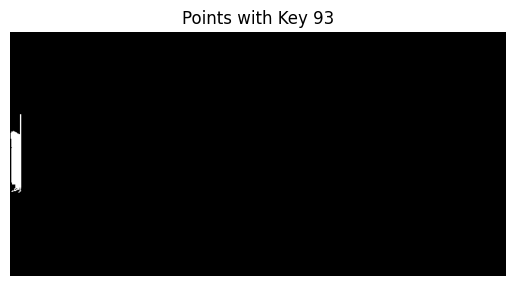

indoor-plant
(368, 749)
204


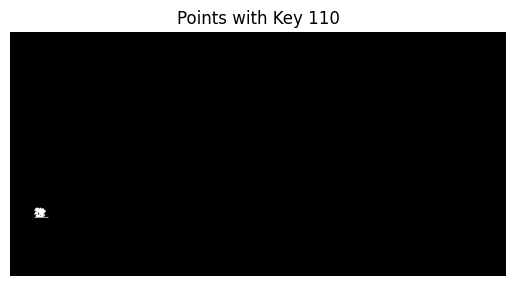

clothing
(368, 749)
210


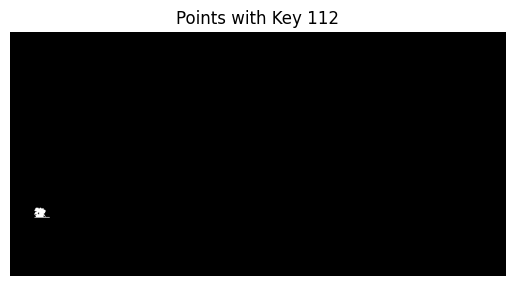

vase
(368, 749)
50


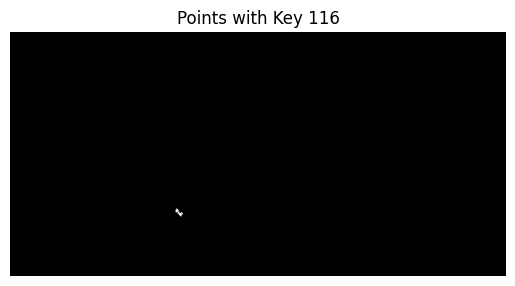

cooktop
(368, 749)
234


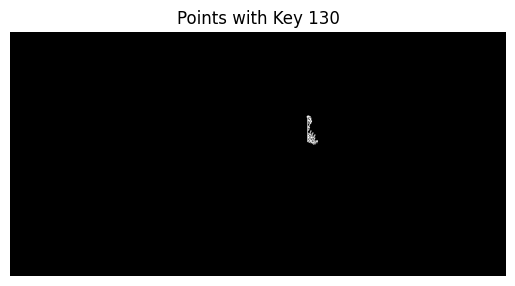

window
(368, 749)
50


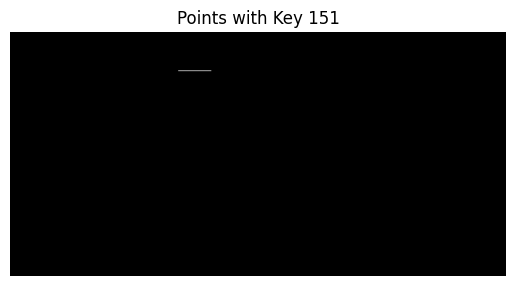

window
(368, 749)
101


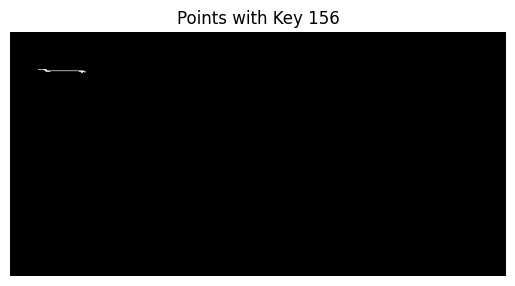

window
(368, 749)
61


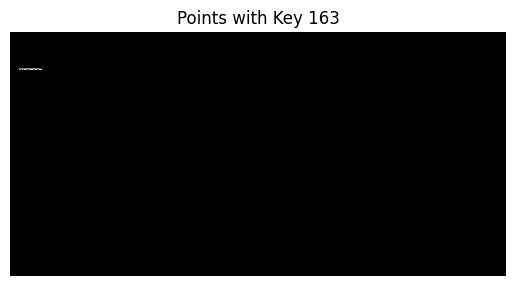

window
(368, 749)
50


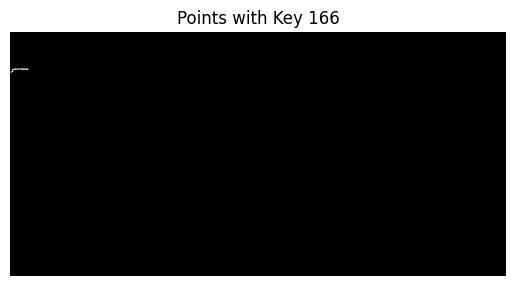

chair
(368, 749)
767


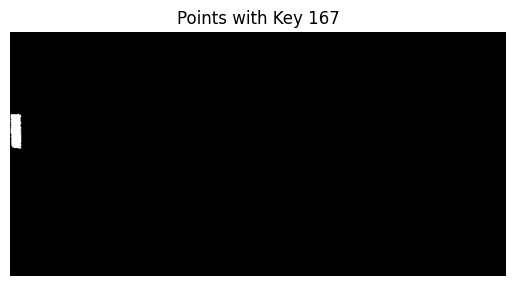

chair
(368, 749)
326


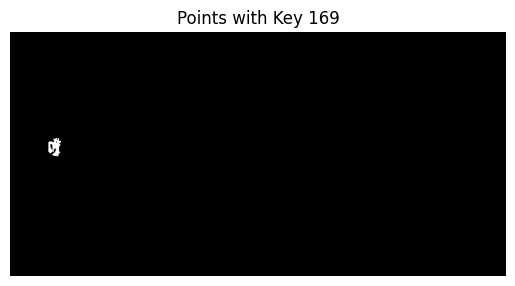

shelf
(368, 749)
494


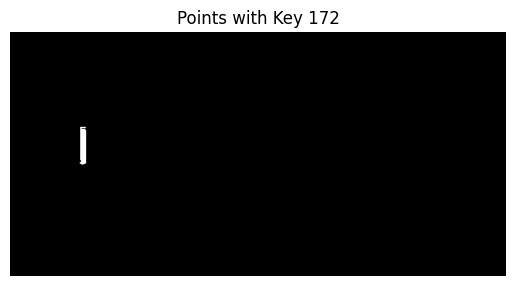

countertop
(368, 749)
331


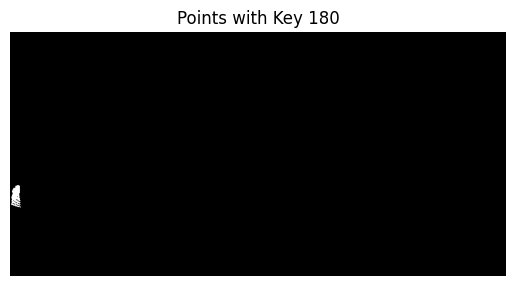

tablet
(368, 749)
95


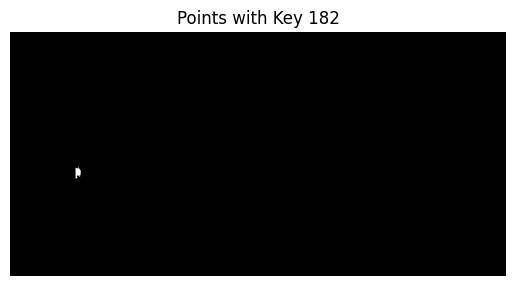

book
(368, 749)
89


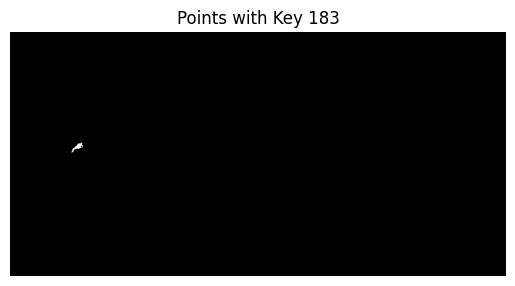

book
(368, 749)
81


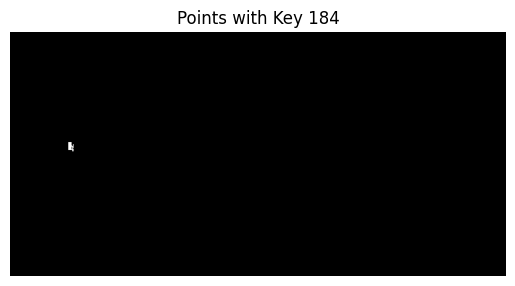

sink
(368, 749)
88


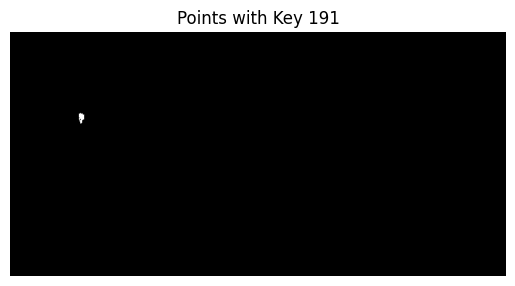

chair
(368, 749)
56


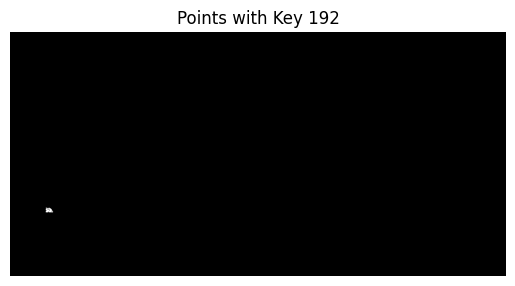

cooktop
(368, 749)
161


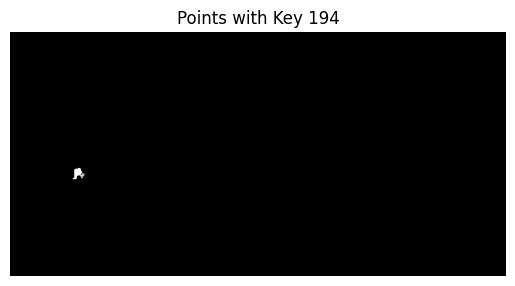

rug
(368, 749)
153


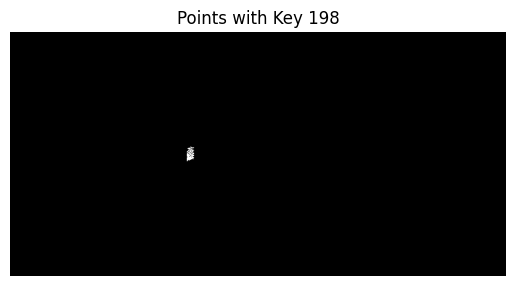

table
(368, 749)
51


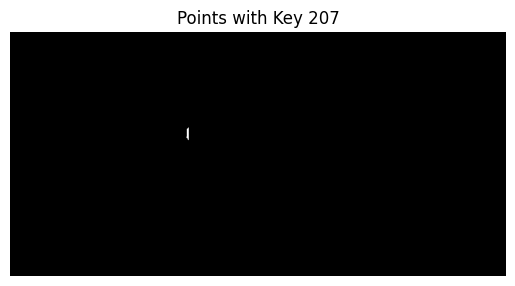

wall-cabinet
(368, 749)
87


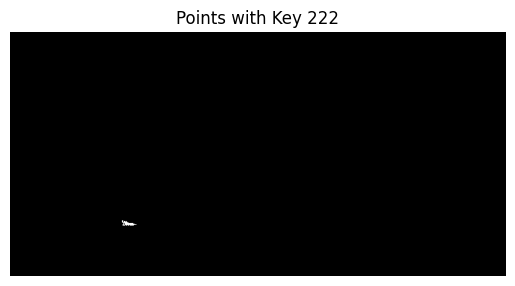

book
(368, 749)
116


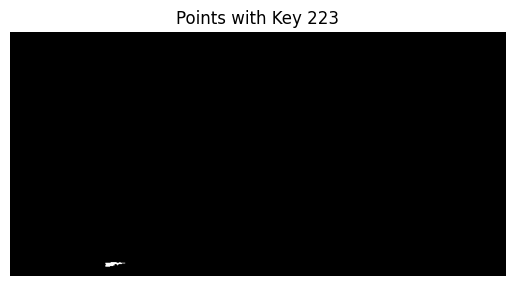

shelf
(368, 749)
284


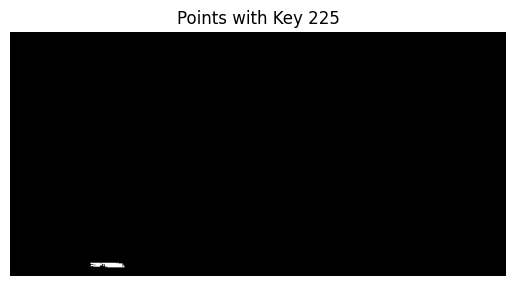

book
(368, 749)
54


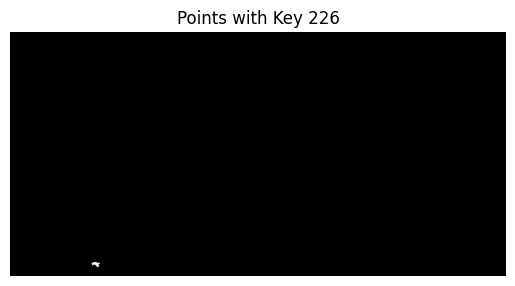

book
(368, 749)
104


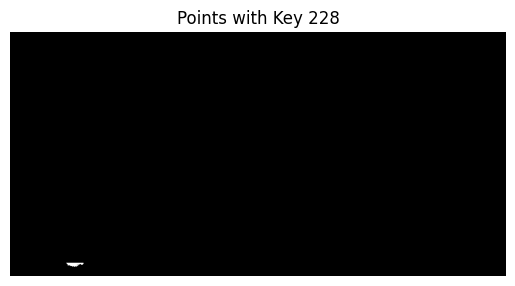

cabinet
(368, 749)
53


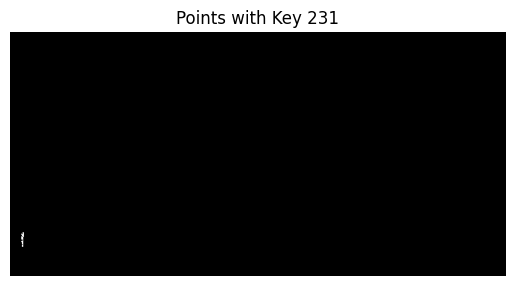

book
(368, 749)
103


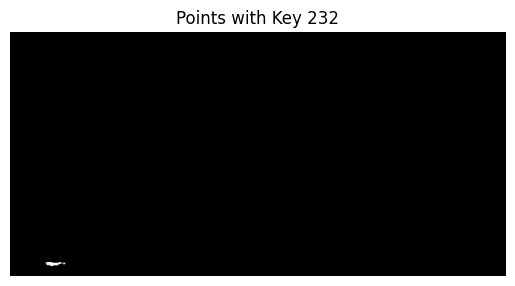

chair
(368, 749)
52


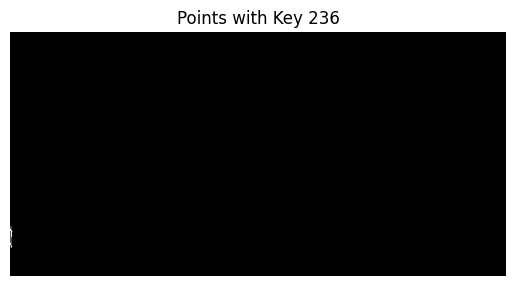

door
(368, 749)
56


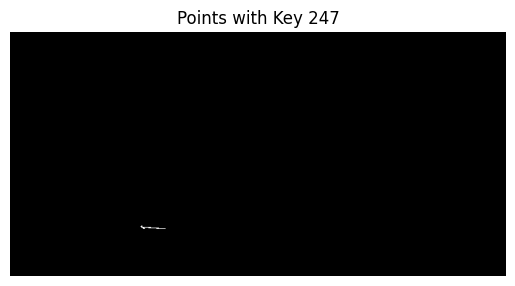

shelf
(368, 749)
87


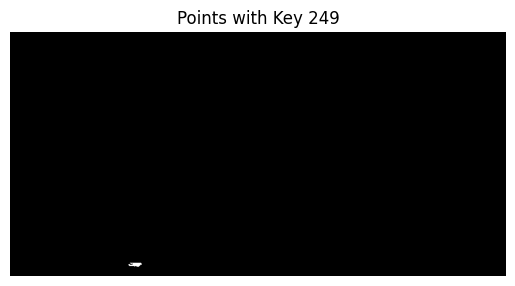

shelf
(368, 749)
121


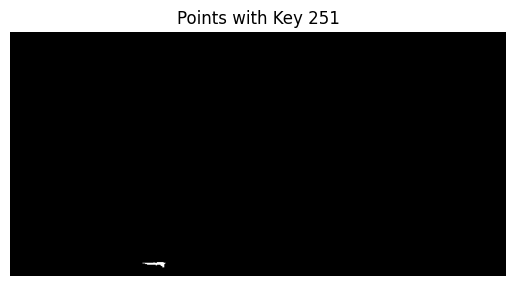

chair
(368, 749)
57


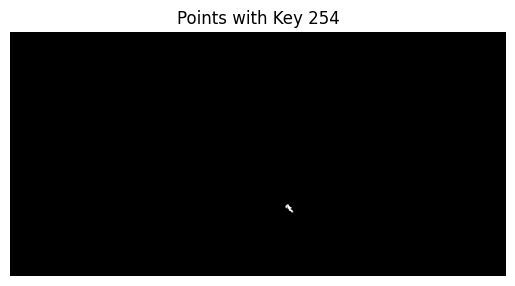

door
(368, 749)
144


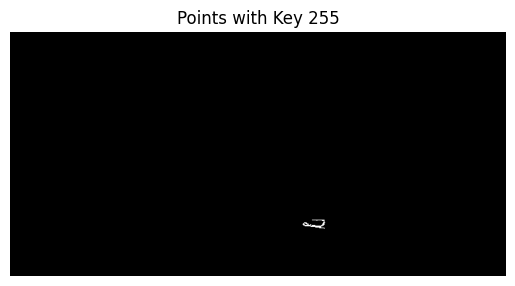

blinds
(368, 749)
331


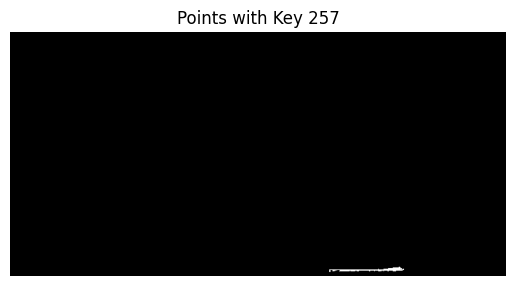

vase
(368, 749)
63


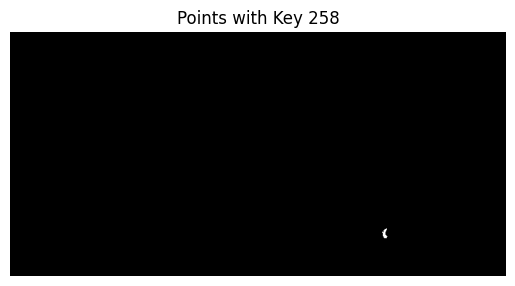

indoor-plant
(368, 749)
257


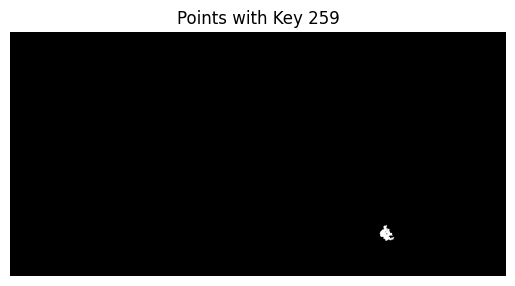

door
(368, 749)
70


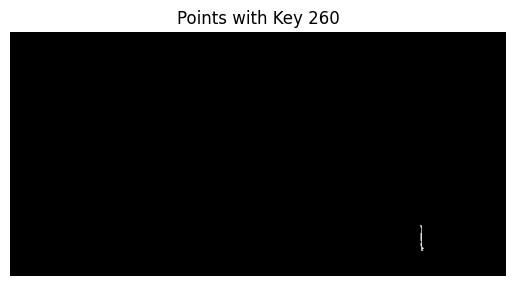

bed
(368, 749)
153


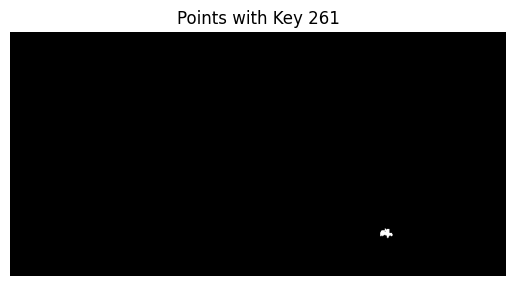

door
(368, 749)
276


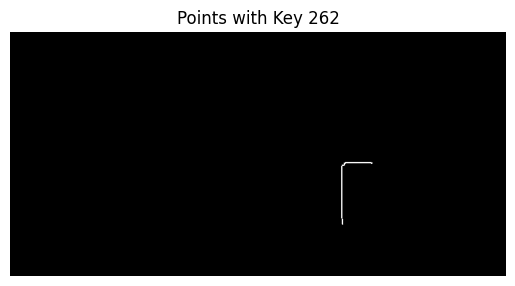

countertop
(368, 749)
202


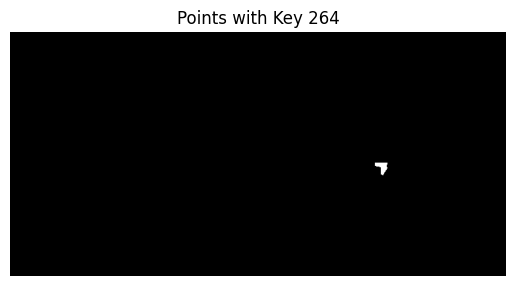

chair
(368, 749)
148


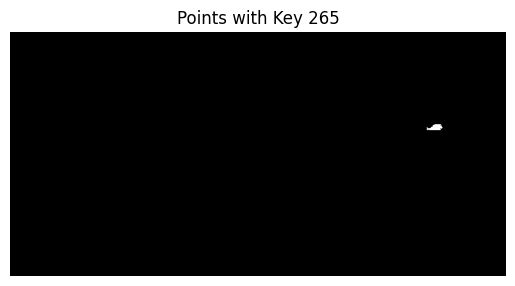

sculpture
(368, 749)
150


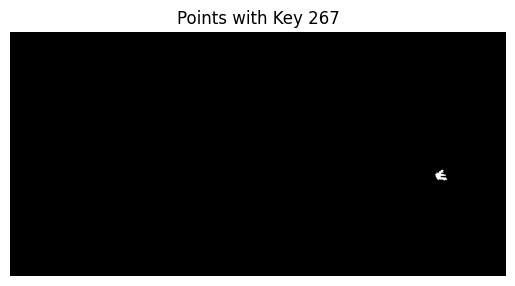

toilet
(368, 749)
152


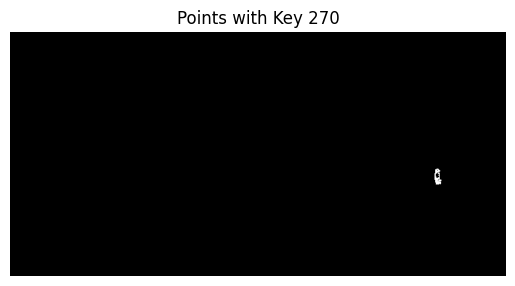

window
(368, 749)
471


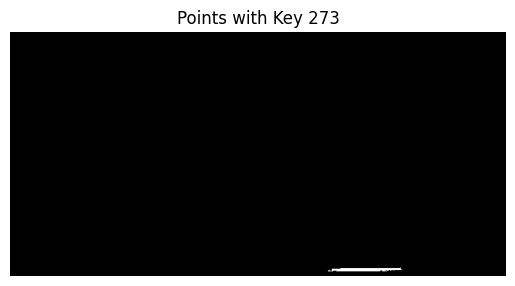

stair
(368, 749)
312


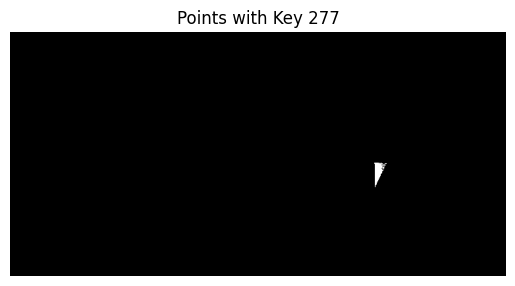

book
(368, 749)
50


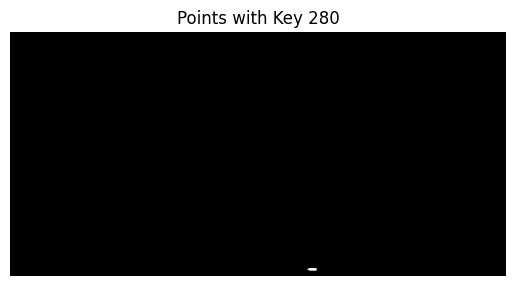

In [20]:
# # 좌표에 0이 키값으로 있는 포인트만 선택하여 ggrid_map 생성
# ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# for i in range(grid.shape[0]):
#     for j in range(grid.shape[1]):
#         if 5 in grid[i, j]:
#             ggrid_map[i, j] = 1  # 0 키를 가진 포인트는 1로 표시

# # 시각화를 위해 1이 있는 곳만 표시
# plt.figure(figsize=(10, 6), dpi=120)
# plt.imshow(ggrid_map, cmap="gray")
# plt.axis('off')
# plt.title("Points with Key 0")
# plt.show()

import numpy as np
import matplotlib.pyplot as plt

# 시각화를 위한 설정
plt.figure(figsize=(10, 6), dpi=120)
print(len(embeddings.keys()))
print(embeddings.keys())
# k값을 0부터 287까지 변경하면서 시각화
for n,id in enumerate(embeddings.keys()):
    # 좌표에 k가 키값으로 있는 포인트만 선택하여 ggrid_map 생성
    ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if id in grid[i, j]:
                ggrid_map[i, j] = 1  # k 키를 가진 포인트는 1로 표시
    # maskk = embeddings[id]["mask"]
    # print(maskk.shape)
    # print(np.sum(maskk))
    # # 시각화를 위해 1이 있는 곳만 표시
    # plt.clf()  # 이전 이미지 지우기
    # plt.imshow(maskk, cmap="gray")
    if n==0:
        np.save(os.path.join(map_save_dir, f"wall_mask.npy"), ggrid_map)

    plt.clf()  # 이전 이미지 지우기
    name = predicts[n]
    print(q_new[name])
    print(ggrid_map.shape)

    print(np.sum(ggrid_map))
    plt.imshow(ggrid_map, cmap="gray")


    plt.axis('off')
    plt.title(f"Points with Key {id}")
    plt.draw()  # 현재 상태를 그리기
    plt.pause(0.5)  # 0.5초 간격으로 업데이트 (시간 조정 가능)

    plt.show()